# Ambiente 🏡

In [1]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 16.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import dask.dataframe as dd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv1D, Flatten, LSTM
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dtype_dict = {
    'MATRICULA': 'object',
    'REFERENCIA': 'datetime',
    'CONSUMO_MEDIDO': 'float32',
    'VOLUME_ESTIMADO': 'float32',
    'VOLUME_ESTIMADO_ACUM': 'float32',
    'FATURADO_MEDIA': 'object'
}

In [5]:
# data = dd.read_csv('/content/drive/Shareddrives/AEGEA/DADOS/CONSUMO/CONSUMO_TOTAL_TOTAL_V0.csv', delimiter=';', assume_missing=True, dtype=dtype_dict)
# data_consumo_fraude = dd.read_csv('/content/drive/Shareddrives/AEGEA/DADOS/CONSUMO_TOTAL_V0_TESTE.csv', delimiter=';', assume_missing=True, dtype=dtype_dict)

data_consumo_fraude = dd.read_parquet('/content/drive/Shareddrives/AEGEA/DADOS/CONSUMO_TOTAL_BCB.parquet', dtype=dtype_dict)

In [6]:
pd.set_option('display.max_columns', None)

# Tratamento 🔍

In [7]:
data_consumo_fraude.head()

,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,EXCECAO,COD_LATITUDE,COD_LONGITUDE,ANOMES,ANOOS,FRAUDE,anomes,valor_anterior_IGPM,valor_SELIC,valor_anterior_SELIC,valor_IPCA,valor_anterior_IPCA
0,2021-06-01,17233802,813089.0,30.0,14.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.474361,-54.552343,06/21,<NA>,0,21/06,4.10,0.014635,0.014498,0.53,0.83
1,2021-02-01,17245048,1001398.0,30.0,12.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.528353,-54.610628,02/21,<NA>,0,21/02,2.58,0.007469,0.007469,0.86,0.25
2,2021-05-01,17089519,887454.0,30.0,4.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.457875,-54.606836,05/21,<NA>,0,21/05,1.51,0.012856,0.012719,0.83,0.31
3,2021-10-01,17090232,966567.0,32.0,11.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.453813,-54.595881,10/21,<NA>,0,21/10,-0.64,0.024244,0.023965,1.25,1.16
4,2021-05-01,17835648,1122183.0,31.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.460413,-54.614495,05/21,<NA>,0,21/05,1.51,0.012856,0.012719,0.83,0.31


In [8]:
df = data_consumo_fraude
df = df.drop(columns=['anomes'])

In [9]:
df['ANOMES'] = df['ANOMES'].astype('category')
df = df.categorize(columns=['ANOMES'])

## Junção com os dados geográficos

In [10]:
temp = dd.read_parquet('/content/drive/Shareddrives/AEGEA/DADOS/temperatura_campogrande.parquet')


In [11]:
temp.head()

,Ano_Mes,Temperature (°C),Wind Speed (km/h),Wind Direction (°),tipo_dia_dia_util,tipo_dia_fim_de_semana,tipo_dia_feriado
0,2019-01-01,28.003226,8.051613,51.645161,22,8,1
1,2019-02-01,26.885714,7.850000,111.285714,20,8,0
2,2019-03-01,26.332258,7.616129,81.612903,21,10,0
3,2019-04-01,25.316667,7.010000,107.400000,21,7,2
4,2019-05-01,22.535714,9.746429,106.785714,19,8,1


In [12]:
# Transformar Ano_Mes em 06/21
temp['ANOMES'] = temp['Ano_Mes'].astype(str)
temp['ANOMES'] = temp['ANOMES'].str[-2:] + '/' + temp['ANOMES'].str[:4]

In [13]:
temp.head()

,Ano_Mes,Temperature (°C),Wind Speed (km/h),Wind Direction (°),tipo_dia_dia_util,tipo_dia_fim_de_semana,tipo_dia_feriado,ANOMES
0,2019-01-01,28.003226,8.051613,51.645161,22,8,1,01/2019
1,2019-02-01,26.885714,7.850000,111.285714,20,8,0,01/2019
2,2019-03-01,26.332258,7.616129,81.612903,21,10,0,01/2019
3,2019-04-01,25.316667,7.010000,107.400000,21,7,2,01/2019
4,2019-05-01,22.535714,9.746429,106.785714,19,8,1,01/2019


In [14]:
def convert_date(x):
    if pd.isna(x):
        return x
    # Converter para string no formato 'MM/AAAA'
    x_str = x.strftime('%m/%Y')
    # Aplicar slicing para obter o formato 'MM/AA'
    return x_str[:3] + x_str[-2:]

# Aplicando a função com apply e especificando o tipo de dado esperado (meta)
temp['ANOMES'] = temp['Ano_Mes'].apply(convert_date, meta=('ANOMES', 'object'))

# Computando o resultado
df_result = temp.compute()

In [15]:
df_result.head()

,Ano_Mes,Temperature (°C),Wind Speed (km/h),Wind Direction (°),tipo_dia_dia_util,tipo_dia_fim_de_semana,tipo_dia_feriado,ANOMES
0,2019-01-01,28.003226,8.051613,51.645161,22,8,1,01/19
1,2019-02-01,26.885714,7.850000,111.285714,20,8,0,02/19
2,2019-03-01,26.332258,7.616129,81.612903,21,10,0,03/19
3,2019-04-01,25.316667,7.010000,107.400000,21,7,2,04/19
4,2019-05-01,22.535714,9.746429,106.785714,19,8,1,05/19


In [16]:
df = df.merge(df_result, on='ANOMES', how='left')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/multi.py:520: UserWarning: Merging dataframes with merge column data type mismatches: 
+----------------------+------------+-------------+
| Merge columns        | left dtype | right dtype |
+----------------------+------------+-------------+
| ('ANOMES', 'ANOMES') | category   | string      |
+----------------------+------------+-------------+
Cast dtypes explicitly to avoid unexpected results.
  warnings.warn(


In [17]:
df.compute()

,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,EXCECAO,COD_LATITUDE,COD_LONGITUDE,ANOMES,ANOOS,FRAUDE,valor_anterior_IGPM,valor_SELIC,valor_anterior_SELIC,valor_IPCA,valor_anterior_IPCA,Ano_Mes,Temperature (°C),Wind Speed (km/h),Wind Direction (°),tipo_dia_dia_util,tipo_dia_fim_de_semana,tipo_dia_feriado
0,2021-06-01,17233802,813089.0,30.0,14.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.474361,-54.552343,06/21,<NA>,0,4.10,0.014635,0.014498,0.53,0.83,2021-06-01,21.670000,8.743333,151.866667,22,8,0
1,2021-02-01,17245048,1001398.0,30.0,12.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.528353,-54.610628,02/21,<NA>,0,2.58,0.007469,0.007469,0.86,0.25,2021-02-01,24.362963,7.574074,159.888889,19,8,0
2,2021-05-01,17089519,887454.0,30.0,4.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.457875,-54.606836,05/21,<NA>,0,1.51,0.012856,0.012719,0.83,0.31,2021-05-01,23.154839,6.967742,224.516129,21,9,1
3,2021-10-01,17090232,966567.0,32.0,11.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.453813,-54.595881,10/21,<NA>,0,-0.64,0.024244,0.023965,1.25,1.16,2021-10-01,26.712903,10.319355,182.935484,19,10,2
4,2021-05-01,17835648,1122183.0,31.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.460413,-54.614495,05/21,<NA>,0,1.51,0.012856,0.012719,0.83,0.31,2021-05-01,23.154839,6.967742,224.516129,21,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4957273,2021-02-01,17582391,1039300.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.516003,-54.668869,02/21,<NA>,0,2.58,0.007469,0.007469,0.86,0.25,2021-02-01,24.362963,7.574074,159.888889,19,8,0
4957274,2021-03-01,1736441,177835.0,30.0,0.0,Hidrometrado,RESIDENCIAL,RES. SOCIAL,10.0,10.0,MEDIA,Normal,-20.491239,-54.631760,03/21,<NA>,0,2.53,0.008734,0.008608,0.93,0.86,2021-03-01,25.487097,5.058065,136.000000,23,8,0
4957275,2021-02-01,1782928,334340.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.464472,-54.521082,02/21,<NA>,0,2.58,0.007469,0.007469,0.86,0.25,2021-02-01,24.362963,7.574074,159.888889,19,8,0
4957276,2021-02-01,17730829,1065042.0,29.0,0.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,10.0,10.0,MEDIA,Normal,-20.528720,-54.636929,02/21,<NA>,0,2.58,0.007469,0.007469,0.86,0.25,2021-02-01,24.362963,7.574074,159.888889,19,8,0


## Transpor

In [18]:
# df_sample = df.sample(frac=0.01, random_state=1)

In [19]:
df.head()

,REFERENCIA,MATRICULA,SEQ_RESPONSAVEL,DIAS_LEITURA,CONS_MEDIDO,TIPO_LIGACAO,CATEGORIA,SUB_CATEGORIA,VOLUME_ESTIMADO,VOLUME_ESTIMADO_ACUM,FATURADO_MEDIA,EXCECAO,COD_LATITUDE,COD_LONGITUDE,ANOMES,ANOOS,FRAUDE,valor_anterior_IGPM,valor_SELIC,valor_anterior_SELIC,valor_IPCA,valor_anterior_IPCA,Ano_Mes,Temperature (°C),Wind Speed (km/h),Wind Direction (°),tipo_dia_dia_util,tipo_dia_fim_de_semana,tipo_dia_feriado
0,2021-06-01,17233802,813089.0,30.0,14.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.474361,-54.552343,06/21,<NA>,0,4.10,0.014635,0.014498,0.53,0.83,2021-06-01,21.670000,8.743333,151.866667,22,8,0
1,2021-02-01,17245048,1001398.0,30.0,12.0,Hidrometrado,RESIDENCIAL,RESIDENCIAL,0.0,0.0,<NA>,Normal,-20.528353,-54.610628,02/21,<NA>,0,2.58,0.007469,0.007469,0.86,0.25,2021-02-01,24.362963,7.574074,159.888889,19,8,0
2,2021-05-01,17089519,887454.0,30.0,4.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.457875,-54.606836,05/21,<NA>,0,1.51,0.012856,0.012719,0.83,0.31,2021-05-01,23.154839,6.967742,224.516129,21,9,1
3,2021-10-01,17090232,966567.0,32.0,11.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.453813,-54.595881,10/21,<NA>,0,-0.64,0.024244,0.023965,1.25,1.16,2021-10-01,26.712903,10.319355,182.935484,19,10,2
4,2021-05-01,17835648,1122183.0,31.0,0.0,Hidrometrado,COMERCIAL,COMERCIAL,0.0,0.0,<NA>,Normal,-20.460413,-54.614495,05/21,<NA>,0,1.51,0.012856,0.012719,0.83,0.31,2021-05-01,23.154839,6.967742,224.516129,21,9,1


In [20]:
df[['MATRICULA', 'ANOMES', 'valor_anterior_IGPM', 'valor_SELIC']].isnull().sum().compute()

,0
MATRICULA,0
ANOMES,0
valor_anterior_IGPM,0
valor_SELIC,0


In [21]:
# Convertendo a coluna 'ANOMES' para o tipo categórico e garantindo que as categorias sejam conhecidas
df['ANOMES'] = df['ANOMES'].astype('category').cat.as_known()

# Criando a tabela dinâmica para 'CONS_MEDIDO' (soma)
df_cons_medido = df.pivot_table(
    index='MATRICULA',
    columns='ANOMES',
    values='CONS_MEDIDO',
    aggfunc='sum'
)
df_cons_medido.columns = [f"{col}-CONS" for col in df_cons_medido.columns]

# Criando a tabela dinâmica para 'valor_anterior_IGPM' (média)
df_igpm = df.pivot_table(
    index='MATRICULA',
    columns='ANOMES',
    values='valor_anterior_IGPM',
    aggfunc='mean'
)
df_igpm.columns = [f"{col}-IGPM" for col in df_igpm.columns]

# Criando a tabela dinâmica para 'valor_SELIC' (média)
df_selic = df.pivot_table(
    index='MATRICULA',
    columns='ANOMES',
    values='valor_SELIC',
    aggfunc='mean'
)
df_selic.columns = [f"{col}-selic" for col in df_selic.columns]

# Criando a tabela dinâmica para 'valor_IPCA' (média)
df_ipca = df.pivot_table(
    index='MATRICULA',
    columns='ANOMES',
    values='valor_IPCA',
    aggfunc='mean'
)
df_ipca.columns = [f"{col}-ipca" for col in df_ipca.columns]

# Criando tabela dinâmica para 'Temperature (°C)'
df_temp = df.pivot_table(
    index='MATRICULA',
    columns='ANOMES',
    values='Temperature (°C)',
    aggfunc='mean'
)
df_temp.columns = [f"{col}-temp" for col in df_temp.columns]

# Criando tabela dinâmica para 'Wind Direction (°)'
df_wind = df.pivot_table(
    index='MATRICULA',
    columns='ANOMES',
    values='Wind Direction (°)',
    aggfunc='mean'
)
df_wind.columns = [f"{col}-wind" for col in df_wind.columns]

# Criando tabela dinâmica para 'Wind Speed (km/h)'
df_speed = df.pivot_table(
    index='MATRICULA',
    columns='ANOMES',
    values='Wind Speed (km/h)',
    aggfunc='mean'
)
df_speed.columns = [f"{col}-speed" for col in df_speed.columns]

# Criando tabela dinâmica para 'tipo_dia_dia_util'
df_dia_util = df.pivot_table(
    index='MATRICULA',
    columns='ANOMES',
    values='tipo_dia_dia_util',
    aggfunc='mean'
)
df_dia_util.columns = [f"{col}-dia_util" for col in df_dia_util.columns]

# Criando tabela dinâmica para 'tipo_dia_fim_de_semana'
df_fim_semana = df.pivot_table(
    index='MATRICULA',
    columns='ANOMES',
    values='tipo_dia_fim_de_semana',
    aggfunc='mean'
)
df_fim_semana.columns = [f"{col}-fim_semana" for col in df_fim_semana.columns]

# Criando tabela dinâmica para 'tipo_dia_feriado'
df_feriado = df.pivot_table(
    index='MATRICULA',
    columns='ANOMES',
    values='tipo_dia_feriado',
    aggfunc='mean'
    )
df_feriado.columns = [f"{col}-feriado" for col in df_feriado.columns]

# Combinando os DataFrames resultantes
df_combined = dd.concat([df_cons_medido, df_igpm, df_selic, df_ipca, df_temp, df_wind, df_speed, df_dia_util, df_fim_semana, df_feriado], axis=1)

In [22]:
df_combined.head()

,01/21-CONS,01/22-CONS,01/23-CONS,01/24-CONS,02/20-CONS,02/21-CONS,02/23-CONS,03/19-CONS,03/21-CONS,04/19-CONS,04/20-CONS,04/21-CONS,04/23-CONS,05/19-CONS,05/22-CONS,05/24-CONS,06/19-CONS,06/20-CONS,06/21-CONS,07/19-CONS,07/21-CONS,07/23-CONS,07/24-CONS,08/20-CONS,08/21-CONS,08/22-CONS,08/24-CONS,09/19-CONS,10/19-CONS,10/20-CONS,10/21-CONS,10/23-CONS,11/19-CONS,11/20-CONS,11/22-CONS,11/23-CONS,12/19-CONS,12/21-CONS,12/22-CONS,01/19-CONS,01/20-CONS,02/19-CONS,02/22-CONS,02/24-CONS,03/20-CONS,03/22-CONS,03/23-CONS,03/24-CONS,04/22-CONS,04/24-CONS,05/20-CONS,05/21-CONS,05/23-CONS,06/22-CONS,06/23-CONS,06/24-CONS,07/20-CONS,07/22-CONS,08/19-CONS,08/23-CONS,09/20-CONS,09/21-CONS,09/22-CONS,09/23-CONS,10/22-CONS,11/21-CONS,12/20-CONS,12/23-CONS,01/21-IGPM,01/22-IGPM,01/23-IGPM,01/24-IGPM,02/20-IGPM,02/21-IGPM,02/23-IGPM,03/19-IGPM,03/21-IGPM,04/19-IGPM,04/20-IGPM,04/21-IGPM,04/23-IGPM,05/19-IGPM,05/22-IGPM,05/24-IGPM,06/19-IGPM,06/20-IGPM,06/21-IGPM,07/19-IGPM,07/21-IGPM,07/23-IGPM,07/24-IGPM,08/20-IGPM,08/21-IGPM,08/22-IGPM,08/24-IGPM,09/19-IGPM,10/19-IGPM,10/20-IGPM,10/21-IGPM,10/23-IGPM,11/19-IGPM,11/20-IGPM,11/22-IGPM,11/23-IGPM,12/19-IGPM,12/21-IGPM,12/22-IGPM,01/19-IGPM,01/20-IGPM,02/19-IGPM,02/22-IGPM,02/24-IGPM,03/20-IGPM,03/22-IGPM,03/23-IGPM,03/24-IGPM,04/22-IGPM,04/24-IGPM,05/20-IGPM,05/21-IGPM,05/23-IGPM,06/22-IGPM,06/23-IGPM,06/24-IGPM,07/20-IGPM,07/22-IGPM,08/19-IGPM,08/23-IGPM,09/20-IGPM,09/21-IGPM,09/22-IGPM,09/23-IGPM,10/22-IGPM,11/21-IGPM,12/20-IGPM,12/23-IGPM,01/21-selic,01/22-selic,01/23-selic,01/24-selic,02/20-selic,02/21-selic,02/23-selic,03/19-selic,03/21-selic,04/19-selic,04/20-selic,04/21-selic,04/23-selic,05/19-selic,05/22-selic,05/24-selic,06/19-selic,06/20-selic,06/21-selic,07/19-selic,07/21-selic,07/23-selic,07/24-selic,08/20-selic,08/21-selic,08/22-selic,08/24-selic,09/19-selic,10/19-selic,10/20-selic,10/21-selic,10/23-selic,11/19-selic,11/20-selic,11/22-selic,11/23-selic,12/19-selic,12/21-selic,12/22-selic,01/19-selic,01/20-selic,02/19-selic,02/22-selic,02/24-selic,03/20-selic,03/22-selic,03/23-selic,03/24-selic,04/22-selic,04/24-selic,05/20-selic,05/21-selic,05/23-selic,06/22-selic,06/23-selic,06/24-selic,07/20-selic,07/22-selic,08/19-selic,08/23-selic,09/20-selic,09/21-selic,09/22-selic,09/23-selic,10/22-selic,11/21-selic,12/20-selic,12/23-selic,01/21-ipca,01/22-ipca,01/23-ipca,01/24-ipca,02/20-ipca,02/21-ipca,02/23-ipca,03/19-ipca,03/21-ipca,04/19-ipca,04/20-ipca,04/21-ipca,04/23-ipca,05/19-ipca,05/22-ipca,05/24-ipca,06/19-ipca,06/20-ipca,06/21-ipca,07/19-ipca,07/21-ipca,07/23-ipca,07/24-ipca,08/20-ipca,08/21-ipca,08/22-ipca,08/24-ipca,09/19-ipca,10/19-ipca,10/20-ipca,10/21-ipca,10/23-ipca,11/19-ipca,11/20-ipca,11/22-ipca,11/23-ipca,12/19-ipca,12/21-ipca,12/22-ipca,01/19-ipca,01/20-ipca,02/19-ipca,02/22-ipca,02/24-ipca,03/20-ipca,03/22-ipca,03/23-ipca,03/24-ipca,04/22-ipca,04/24-ipca,05/20-ipca,05/21-ipca,05/23-ipca,06/22-ipca,06/23-ipca,06/24-ipca,07/20-ipca,07/22-ipca,08/19-ipca,08/23-ipca,09/20-ipca,09/21-ipca,09/22-ipca,09/23-ipca,10/22-ipca,11/21-ipca,12/20-ipca,12/23-ipca,01/21-temp,01/22-temp,01/23-temp,01/24-temp,02/20-temp,02/21-temp,02/23-temp,03/19-temp,03/21-temp,04/19-temp,04/20-temp,04/21-temp,04/23-temp,05/19-temp,05/22-temp,05/24-temp,06/19-temp,06/20-temp,06/21-temp,07/19-temp,07/21-temp,07/23-temp,07/24-temp,08/20-temp,08/21-temp,08/22-temp,08/24-temp,09/19-temp,10/19-temp,10/20-temp,10/21-temp,10/23-temp,11/19-temp,11/20-temp,11/22-temp,11/23-temp,12/19-temp,12/21-temp,12/22-temp,01/19-temp,01/20-temp,02/19-temp,02/22-temp,02/24-temp,03/20-temp,03/22-temp,03/23-temp,03/24-temp,04/22-temp,04/24-temp,05/20-temp,05/21-temp,05/23-temp,06/22-temp,06/23-temp,06/24-temp,07/20-temp,07/22-temp,08/19-temp,08/23-temp,09/20-temp,09/21-temp,09/22-temp,09/23-temp,10/22-temp,11/21-temp,12/20-temp,12/23-temp,01/21-wind,01/22-wind,01/23-wind,01/24-wind,02/20-wind,02/21-wind,02/23-wind,03/19-wind,03/21-wind,04/19-wind,04/20-wind,04/21-wind,04/23-wind,05/19-wind,05/22-wind,05/24-wind,06/19-wind,06/2

In [25]:
df_combined[df_combined.index == '17075338'].compute()[list(df_combined.columns[df_combined.columns.str.contains('CONS')])]

,01/21-CONS,01/22-CONS,01/23-CONS,01/24-CONS,02/20-CONS,02/21-CONS,02/23-CONS,03/19-CONS,03/21-CONS,04/19-CONS,04/20-CONS,04/21-CONS,04/23-CONS,05/19-CONS,05/22-CONS,05/24-CONS,06/19-CONS,06/20-CONS,06/21-CONS,07/19-CONS,07/21-CONS,07/23-CONS,07/24-CONS,08/20-CONS,08/21-CONS,08/22-CONS,08/24-CONS,09/19-CONS,10/19-CONS,10/20-CONS,10/21-CONS,10/23-CONS,11/19-CONS,11/20-CONS,11/22-CONS,11/23-CONS,12/19-CONS,12/21-CONS,12/22-CONS,01/19-CONS,01/20-CONS,02/19-CONS,02/22-CONS,02/24-CONS,03/20-CONS,03/22-CONS,03/23-CONS,03/24-CONS,04/22-CONS,04/24-CONS,05/20-CONS,05/21-CONS,05/23-CONS,06/22-CONS,06/23-CONS,06/24-CONS,07/20-CONS,07/22-CONS,08/19-CONS,08/23-CONS,09/20-CONS,09/21-CONS,09/22-CONS,09/23-CONS,10/22-CONS,11/21-CONS,12/20-CONS,12/23-CONS
MATRICULA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
17075338,9.0,85.0,8.0,11.0,16.0,16.0,12.0,12.0,16.0,13.0,9.0,13.0,16.0,9.0,19.0,12.0,11.0,10.0,14.0,10.0,13.0,13.0,15.0,18.0,12.0,13.0,23.0,11.0,14.0,12.0,33.0,17.0,11.0,11.0,8.0,17.0,12.0,10.0,10.0,11.0,7.0,8.0,14.0,20.0,9.0,13.0,14.0,12.0,18.0,16.0,10.0,10.0,14.0,11.0,16.0,15.0,14.0,11.0,11.0,18.0,12.0,11.0,13.0,15.0,12.0,48.0,10.0,33.0


In [27]:
df_filled = df_combined.ffill()

## Exportar

In [29]:
df_final = df_filled.reset_index().rename(columns={'index': 'MATRICULA'})

In [30]:
df_final.head()

,MATRICULA,01/21-CONS,01/22-CONS,01/23-CONS,01/24-CONS,02/20-CONS,02/21-CONS,02/23-CONS,03/19-CONS,03/21-CONS,04/19-CONS,04/20-CONS,04/21-CONS,04/23-CONS,05/19-CONS,05/22-CONS,05/24-CONS,06/19-CONS,06/20-CONS,06/21-CONS,07/19-CONS,07/21-CONS,07/23-CONS,07/24-CONS,08/20-CONS,08/21-CONS,08/22-CONS,08/24-CONS,09/19-CONS,10/19-CONS,10/20-CONS,10/21-CONS,10/23-CONS,11/19-CONS,11/20-CONS,11/22-CONS,11/23-CONS,12/19-CONS,12/21-CONS,12/22-CONS,01/19-CONS,01/20-CONS,02/19-CONS,02/22-CONS,02/24-CONS,03/20-CONS,03/22-CONS,03/23-CONS,03/24-CONS,04/22-CONS,04/24-CONS,05/20-CONS,05/21-CONS,05/23-CONS,06/22-CONS,06/23-CONS,06/24-CONS,07/20-CONS,07/22-CONS,08/19-CONS,08/23-CONS,09/20-CONS,09/21-CONS,09/22-CONS,09/23-CONS,10/22-CONS,11/21-CONS,12/20-CONS,12/23-CONS,01/21-IGPM,01/22-IGPM,01/23-IGPM,01/24-IGPM,02/20-IGPM,02/21-IGPM,02/23-IGPM,03/19-IGPM,03/21-IGPM,04/19-IGPM,04/20-IGPM,04/21-IGPM,04/23-IGPM,05/19-IGPM,05/22-IGPM,05/24-IGPM,06/19-IGPM,06/20-IGPM,06/21-IGPM,07/19-IGPM,07/21-IGPM,07/23-IGPM,07/24-IGPM,08/20-IGPM,08/21-IGPM,08/22-IGPM,08/24-IGPM,09/19-IGPM,10/19-IGPM,10/20-IGPM,10/21-IGPM,10/23-IGPM,11/19-IGPM,11/20-IGPM,11/22-IGPM,11/23-IGPM,12/19-IGPM,12/21-IGPM,12/22-IGPM,01/19-IGPM,01/20-IGPM,02/19-IGPM,02/22-IGPM,02/24-IGPM,03/20-IGPM,03/22-IGPM,03/23-IGPM,03/24-IGPM,04/22-IGPM,04/24-IGPM,05/20-IGPM,05/21-IGPM,05/23-IGPM,06/22-IGPM,06/23-IGPM,06/24-IGPM,07/20-IGPM,07/22-IGPM,08/19-IGPM,08/23-IGPM,09/20-IGPM,09/21-IGPM,09/22-IGPM,09/23-IGPM,10/22-IGPM,11/21-IGPM,12/20-IGPM,12/23-IGPM,01/21-selic,01/22-selic,01/23-selic,01/24-selic,02/20-selic,02/21-selic,02/23-selic,03/19-selic,03/21-selic,04/19-selic,04/20-selic,04/21-selic,04/23-selic,05/19-selic,05/22-selic,05/24-selic,06/19-selic,06/20-selic,06/21-selic,07/19-selic,07/21-selic,07/23-selic,07/24-selic,08/20-selic,08/21-selic,08/22-selic,08/24-selic,09/19-selic,10/19-selic,10/20-selic,10/21-selic,10/23-selic,11/19-selic,11/20-selic,11/22-selic,11/23-selic,12/19-selic,12/21-selic,12/22-selic,01/19-selic,01/20-selic,02/19-selic,02/22-selic,02/24-selic,03/20-selic,03/22-selic,03/23-selic,03/24-selic,04/22-selic,04/24-selic,05/20-selic,05/21-selic,05/23-selic,06/22-selic,06/23-selic,06/24-selic,07/20-selic,07/22-selic,08/19-selic,08/23-selic,09/20-selic,09/21-selic,09/22-selic,09/23-selic,10/22-selic,11/21-selic,12/20-selic,12/23-selic,01/21-ipca,01/22-ipca,01/23-ipca,01/24-ipca,02/20-ipca,02/21-ipca,02/23-ipca,03/19-ipca,03/21-ipca,04/19-ipca,04/20-ipca,04/21-ipca,04/23-ipca,05/19-ipca,05/22-ipca,05/24-ipca,06/19-ipca,06/20-ipca,06/21-ipca,07/19-ipca,07/21-ipca,07/23-ipca,07/24-ipca,08/20-ipca,08/21-ipca,08/22-ipca,08/24-ipca,09/19-ipca,10/19-ipca,10/20-ipca,10/21-ipca,10/23-ipca,11/19-ipca,11/20-ipca,11/22-ipca,11/23-ipca,12/19-ipca,12/21-ipca,12/22-ipca,01/19-ipca,01/20-ipca,02/19-ipca,02/22-ipca,02/24-ipca,03/20-ipca,03/22-ipca,03/23-ipca,03/24-ipca,04/22-ipca,04/24-ipca,05/20-ipca,05/21-ipca,05/23-ipca,06/22-ipca,06/23-ipca,06/24-ipca,07/20-ipca,07/22-ipca,08/19-ipca,08/23-ipca,09/20-ipca,09/21-ipca,09/22-ipca,09/23-ipca,10/22-ipca,11/21-ipca,12/20-ipca,12/23-ipca,01/21-temp,01/22-temp,01/23-temp,01/24-temp,02/20-temp,02/21-temp,02/23-temp,03/19-temp,03/21-temp,04/19-temp,04/20-temp,04/21-temp,04/23-temp,05/19-temp,05/22-temp,05/24-temp,06/19-temp,06/20-temp,06/21-temp,07/19-temp,07/21-temp,07/23-temp,07/24-temp,08/20-temp,08/21-temp,08/22-temp,08/24-temp,09/19-temp,10/19-temp,10/20-temp,10/21-temp,10/23-temp,11/19-temp,11/20-temp,11/22-temp,11/23-temp,12/19-temp,12/21-temp,12/22-temp,01/19-temp,01/20-temp,02/19-temp,02/22-temp,02/24-temp,03/20-temp,03/22-temp,03/23-temp,03/24-temp,04/22-temp,04/24-temp,05/20-temp,05/21-temp,05/23-temp,06/22-temp,06/23-temp,06/24-temp,07/20-temp,07/22-temp,08/19-temp,08/23-temp,09/20-temp,09/21-temp,09/22-temp,09/23-temp,10/22-temp,11/21-temp,12/20-temp,12/23-temp,01/21-wind,01/22-wind,01/23-wind,01/24-wind,02/20-wind,02/21-wind,02/23-wind,03/19-wind,03/21-wind,04/19-wind,04/20-wind,04/21-wind,04/23-wind,05/19-wind,05/22-wind,05/24-wind,06/19

In [31]:
df_final = df_final.merge(data_consumo_fraude[['MATRICULA', 'FRAUDE', 'CATEGORIA']].drop_duplicates(), on='MATRICULA', how='left')

In [34]:
# df_final.compute().shape

In [36]:
#  df_final.to_parquet('/content/drive/Shareddrives/AEGEA/DADOS/CONSUMO_TOTAL_BCB_TRANS_3.parquet')

# Modelagem 🧠

### Balanceamento e OHE ⚖️

In [38]:
df_input = dd.read_parquet('/content/drive/Shareddrives/AEGEA/DADOS/CONSUMO_TOTAL_BCB_TRANS_3.parquet', dtype=dtype_dict)

In [39]:
df_input.head()

,MATRICULA,01/21-CONS,01/22-CONS,01/23-CONS,01/24-CONS,02/20-CONS,02/21-CONS,02/23-CONS,03/19-CONS,03/21-CONS,04/19-CONS,04/20-CONS,04/21-CONS,04/23-CONS,05/19-CONS,05/22-CONS,05/24-CONS,06/19-CONS,06/20-CONS,06/21-CONS,07/19-CONS,07/21-CONS,07/23-CONS,07/24-CONS,08/20-CONS,08/21-CONS,08/22-CONS,08/24-CONS,09/19-CONS,10/19-CONS,10/20-CONS,10/21-CONS,10/23-CONS,11/19-CONS,11/20-CONS,11/22-CONS,11/23-CONS,12/19-CONS,12/21-CONS,12/22-CONS,01/19-CONS,01/20-CONS,02/19-CONS,02/22-CONS,02/24-CONS,03/20-CONS,03/22-CONS,03/23-CONS,03/24-CONS,04/22-CONS,04/24-CONS,05/20-CONS,05/21-CONS,05/23-CONS,06/22-CONS,06/23-CONS,06/24-CONS,07/20-CONS,07/22-CONS,08/19-CONS,08/23-CONS,09/20-CONS,09/21-CONS,09/22-CONS,09/23-CONS,10/22-CONS,11/21-CONS,12/20-CONS,12/23-CONS,01/21-IGPM,01/22-IGPM,01/23-IGPM,01/24-IGPM,02/20-IGPM,02/21-IGPM,02/23-IGPM,03/19-IGPM,03/21-IGPM,04/19-IGPM,04/20-IGPM,04/21-IGPM,04/23-IGPM,05/19-IGPM,05/22-IGPM,05/24-IGPM,06/19-IGPM,06/20-IGPM,06/21-IGPM,07/19-IGPM,07/21-IGPM,07/23-IGPM,07/24-IGPM,08/20-IGPM,08/21-IGPM,08/22-IGPM,08/24-IGPM,09/19-IGPM,10/19-IGPM,10/20-IGPM,10/21-IGPM,10/23-IGPM,11/19-IGPM,11/20-IGPM,11/22-IGPM,11/23-IGPM,12/19-IGPM,12/21-IGPM,12/22-IGPM,01/19-IGPM,01/20-IGPM,02/19-IGPM,02/22-IGPM,02/24-IGPM,03/20-IGPM,03/22-IGPM,03/23-IGPM,03/24-IGPM,04/22-IGPM,04/24-IGPM,05/20-IGPM,05/21-IGPM,05/23-IGPM,06/22-IGPM,06/23-IGPM,06/24-IGPM,07/20-IGPM,07/22-IGPM,08/19-IGPM,08/23-IGPM,09/20-IGPM,09/21-IGPM,09/22-IGPM,09/23-IGPM,10/22-IGPM,11/21-IGPM,12/20-IGPM,12/23-IGPM,01/21-selic,01/22-selic,01/23-selic,01/24-selic,02/20-selic,02/21-selic,02/23-selic,03/19-selic,03/21-selic,04/19-selic,04/20-selic,04/21-selic,04/23-selic,05/19-selic,05/22-selic,05/24-selic,06/19-selic,06/20-selic,06/21-selic,07/19-selic,07/21-selic,07/23-selic,07/24-selic,08/20-selic,08/21-selic,08/22-selic,08/24-selic,09/19-selic,10/19-selic,10/20-selic,10/21-selic,10/23-selic,11/19-selic,11/20-selic,11/22-selic,11/23-selic,12/19-selic,12/21-selic,12/22-selic,01/19-selic,01/20-selic,02/19-selic,02/22-selic,02/24-selic,03/20-selic,03/22-selic,03/23-selic,03/24-selic,04/22-selic,04/24-selic,05/20-selic,05/21-selic,05/23-selic,06/22-selic,06/23-selic,06/24-selic,07/20-selic,07/22-selic,08/19-selic,08/23-selic,09/20-selic,09/21-selic,09/22-selic,09/23-selic,10/22-selic,11/21-selic,12/20-selic,12/23-selic,01/21-ipca,01/22-ipca,01/23-ipca,01/24-ipca,02/20-ipca,02/21-ipca,02/23-ipca,03/19-ipca,03/21-ipca,04/19-ipca,04/20-ipca,04/21-ipca,04/23-ipca,05/19-ipca,05/22-ipca,05/24-ipca,06/19-ipca,06/20-ipca,06/21-ipca,07/19-ipca,07/21-ipca,07/23-ipca,07/24-ipca,08/20-ipca,08/21-ipca,08/22-ipca,08/24-ipca,09/19-ipca,10/19-ipca,10/20-ipca,10/21-ipca,10/23-ipca,11/19-ipca,11/20-ipca,11/22-ipca,11/23-ipca,12/19-ipca,12/21-ipca,12/22-ipca,01/19-ipca,01/20-ipca,02/19-ipca,02/22-ipca,02/24-ipca,03/20-ipca,03/22-ipca,03/23-ipca,03/24-ipca,04/22-ipca,04/24-ipca,05/20-ipca,05/21-ipca,05/23-ipca,06/22-ipca,06/23-ipca,06/24-ipca,07/20-ipca,07/22-ipca,08/19-ipca,08/23-ipca,09/20-ipca,09/21-ipca,09/22-ipca,09/23-ipca,10/22-ipca,11/21-ipca,12/20-ipca,12/23-ipca,01/21-temp,01/22-temp,01/23-temp,01/24-temp,02/20-temp,02/21-temp,02/23-temp,03/19-temp,03/21-temp,04/19-temp,04/20-temp,04/21-temp,04/23-temp,05/19-temp,05/22-temp,05/24-temp,06/19-temp,06/20-temp,06/21-temp,07/19-temp,07/21-temp,07/23-temp,07/24-temp,08/20-temp,08/21-temp,08/22-temp,08/24-temp,09/19-temp,10/19-temp,10/20-temp,10/21-temp,10/23-temp,11/19-temp,11/20-temp,11/22-temp,11/23-temp,12/19-temp,12/21-temp,12/22-temp,01/19-temp,01/20-temp,02/19-temp,02/22-temp,02/24-temp,03/20-temp,03/22-temp,03/23-temp,03/24-temp,04/22-temp,04/24-temp,05/20-temp,05/21-temp,05/23-temp,06/22-temp,06/23-temp,06/24-temp,07/20-temp,07/22-temp,08/19-temp,08/23-temp,09/20-temp,09/21-temp,09/22-temp,09/23-temp,10/22-temp,11/21-temp,12/20-temp,12/23-temp,01/21-wind,01/22-wind,01/23-wind,01/24-wind,02/20-wind,02/21-wind,02/23-wind,03/19-wind,03/21-wind,04/19-wind,04/20-wind,04/21-wind,04/23-wind,05/19-wind,05/22-wind,05/24-wind,06/19

In [40]:
df_input['CATEGORIA'].value_counts().compute()

,count
CATEGORIA,
PUBLICA,1898
COMERCIAL,55333
INDUSTRIAL,115
RESIDENCIAL,481824


In [41]:
# Definir as categorias e seus códigos
categorias = ['RESIDENCIAL', 'COMERCIAL', 'INDUSTRIAL', 'PUBLICA']
codigos = [1, 2, 3, 4]

# Adicionar uma coluna dummy para cada categoria
for categoria, codigo in zip(categorias, codigos):
    df_input[f'CATEGORIA_{categoria}'] = (df_input['CATEGORIA'] == categoria).astype('int64')

# Drop a coluna original 'CATEGORIA'
df_input = df_input.drop(columns=['CATEGORIA'])

# Calcular o DataFrame Dask
df_output = df_input.compute()

print(df_output)


       MATRICULA  01/21-CONS  01/22-CONS  01/23-CONS  01/24-CONS  02/20-CONS  \
0       17000001         1.0         4.0         2.0         6.0         2.0   
1       17075331         0.0        11.0         6.0         3.0         8.0   
2       17075335         5.0         6.0         0.0         1.0         4.0   
3       17075335         5.0         6.0         0.0         1.0         4.0   
4       17075342        19.0        19.0        22.0        20.0        26.0   
...          ...         ...         ...         ...         ...         ...   
179655  17997529         0.0         0.0         0.0         0.0         0.0   
179656  17997552         0.0         0.0         0.0         0.0         0.0   
179657  17997585         0.0         0.0         0.0         0.0         0.0   
179658  17997635         0.0         0.0         0.0         0.0         0.0   
179659  17997639         0.0         0.0         0.0         0.0         0.0   

        02/21-CONS  02/23-CONS  03/19-C

In [42]:
# Balanceamento
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
# Ver a distribuição original
print("Distribuição antes do undersampling:", Counter(df_output['FRAUDE']))
X = df_output.drop(columns = ['FRAUDE', 'MATRICULA', 'CATEGORIA_RESIDENCIAL', 'CATEGORIA_COMERCIAL', 'CATEGORIA_PUBLICA', 'CATEGORIA_INDUSTRIAL'], axis=1)
y = df_output['FRAUDE']
# Definindo o undersampler para balancear 50/50
undersample = RandomUnderSampler(sampling_strategy=1.0)  # Proporção 1:1 (50/50)
X_resampled, y_resampled = undersample.fit_resample(X, y)

# Ver a distribuição após o undersampling
print("Distribuição após o undersampling:", Counter(y_resampled))

Distribuição antes do undersampling: Counter({0: 414698, 1: 124472})
Distribuição após o undersampling: Counter({0: 124472, 1: 124472})


In [43]:
X_resampled.columns

Index(['01/21-CONS', '01/22-CONS', '01/23-CONS', '01/24-CONS', '02/20-CONS',
       '02/21-CONS', '02/23-CONS', '03/19-CONS', '03/21-CONS', '04/19-CONS',
       ...
       '08/19-feriado', '08/23-feriado', '09/20-feriado', '09/21-feriado',
       '09/22-feriado', '09/23-feriado', '10/22-feriado', '11/21-feriado',
       '12/20-feriado', '12/23-feriado'],
      dtype='object', length=680)

## Rede Neural

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [92]:
print(X_resampled.shape)
print(y_resampled.shape)
print(X_train.shape)
print(y_train.shape)

(248944, 680)
(248944,)
(174260, 680)
(174260,)


In [93]:
model = Sequential()

# input layer
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# 1
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# 2
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# 3
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
# 4
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall', 'F1Score'])
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                     │ (None, 128)                 │          87,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 104,033 (406.38 KB)

 Trainable params: 103,393 (403.88 KB)

 Non-trainable params: 640 (2.50 KB)

In [95]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split=0.3)
model.summary()

Epoch 1/10
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - F1Score: 0.6656 - Recall: 0.4348 - accuracy: 0.5405 - loss: 0.6881 - val_F1Score: 0.6658 - val_Recall: 0.9957 - val_accuracy: 0.4996 - val_loss: 0.7595
Epoch 2/10
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - F1Score: 0.6671 - Recall: 0.4708 - accuracy: 0.5434 - loss: 0.6879 - val_F1Score: 0.6658 - val_Recall: 0.7318 - val_accuracy: 0.5084 - val_loss: 0.6937
Epoch 3/10
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - F1Score: 0.6658 - Recall: 0.4377 - accuracy: 0.5386 - loss: 0.6889 - val_F1Score: 0.6658 - val_Recall: 0.9994 - val_accuracy: 0.4993 - val_loss: 1.1009
Epoch 4/10
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - F1Score: 0.6663 - Recall: 0.4531 - accuracy: 0.5393 - loss: 0.6890 - val_F1Score: 0.6658 - val_Recall: 0.0284 - val_accuracy: 0.5057 - val_loss: 0.6969
Epoch 5/10
1906/1906 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - F1Score: 0.6660 - Recall: 0.4537 - accuracy: 0.5484 - loss: 0.6871 - val_F1Score: 0.6658 - val_Recall: 0.9228 - 

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                     │ (None, 128)                 │          87,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 310,821 (1.19 MB)

 Trainable params: 103,393 (403.88 KB)

 Non-trainable params: 640 (2.50 KB)

 Optimizer params: 206,788 (807.77 KB)

2334/2334 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


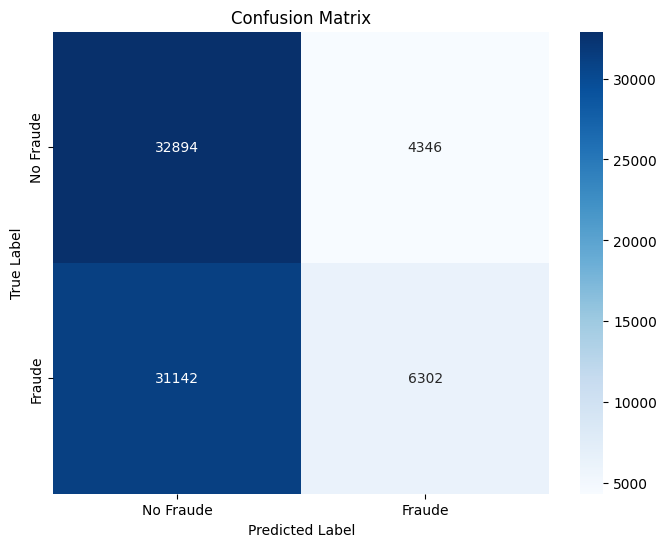

In [96]:
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Fraude', 'Fraude'],
            yticklabels=['No Fraude', 'Fraude'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## Rede Neural Recorrente

In [46]:
X_resampled.head()

,01/21-CONS,01/22-CONS,01/23-CONS,01/24-CONS,02/20-CONS,02/21-CONS,02/23-CONS,03/19-CONS,03/21-CONS,04/19-CONS,04/20-CONS,04/21-CONS,04/23-CONS,05/19-CONS,05/22-CONS,05/24-CONS,06/19-CONS,06/20-CONS,06/21-CONS,07/19-CONS,07/21-CONS,07/23-CONS,07/24-CONS,08/20-CONS,08/21-CONS,08/22-CONS,08/24-CONS,09/19-CONS,10/19-CONS,10/20-CONS,10/21-CONS,10/23-CONS,11/19-CONS,11/20-CONS,11/22-CONS,11/23-CONS,12/19-CONS,12/21-CONS,12/22-CONS,01/19-CONS,01/20-CONS,02/19-CONS,02/22-CONS,02/24-CONS,03/20-CONS,03/22-CONS,03/23-CONS,03/24-CONS,04/22-CONS,04/24-CONS,05/20-CONS,05/21-CONS,05/23-CONS,06/22-CONS,06/23-CONS,06/24-CONS,07/20-CONS,07/22-CONS,08/19-CONS,08/23-CONS,09/20-CONS,09/21-CONS,09/22-CONS,09/23-CONS,10/22-CONS,11/21-CONS,12/20-CONS,12/23-CONS,01/21-IGPM,01/22-IGPM,01/23-IGPM,01/24-IGPM,02/20-IGPM,02/21-IGPM,02/23-IGPM,03/19-IGPM,03/21-IGPM,04/19-IGPM,04/20-IGPM,04/21-IGPM,04/23-IGPM,05/19-IGPM,05/22-IGPM,05/24-IGPM,06/19-IGPM,06/20-IGPM,06/21-IGPM,07/19-IGPM,07/21-IGPM,07/23-IGPM,07/24-IGPM,08/20-IGPM,08/21-IGPM,08/22-IGPM,08/24-IGPM,09/19-IGPM,10/19-IGPM,10/20-IGPM,10/21-IGPM,10/23-IGPM,11/19-IGPM,11/20-IGPM,11/22-IGPM,11/23-IGPM,12/19-IGPM,12/21-IGPM,12/22-IGPM,01/19-IGPM,01/20-IGPM,02/19-IGPM,02/22-IGPM,02/24-IGPM,03/20-IGPM,03/22-IGPM,03/23-IGPM,03/24-IGPM,04/22-IGPM,04/24-IGPM,05/20-IGPM,05/21-IGPM,05/23-IGPM,06/22-IGPM,06/23-IGPM,06/24-IGPM,07/20-IGPM,07/22-IGPM,08/19-IGPM,08/23-IGPM,09/20-IGPM,09/21-IGPM,09/22-IGPM,09/23-IGPM,10/22-IGPM,11/21-IGPM,12/20-IGPM,12/23-IGPM,01/21-selic,01/22-selic,01/23-selic,01/24-selic,02/20-selic,02/21-selic,02/23-selic,03/19-selic,03/21-selic,04/19-selic,04/20-selic,04/21-selic,04/23-selic,05/19-selic,05/22-selic,05/24-selic,06/19-selic,06/20-selic,06/21-selic,07/19-selic,07/21-selic,07/23-selic,07/24-selic,08/20-selic,08/21-selic,08/22-selic,08/24-selic,09/19-selic,10/19-selic,10/20-selic,10/21-selic,10/23-selic,11/19-selic,11/20-selic,11/22-selic,11/23-selic,12/19-selic,12/21-selic,12/22-selic,01/19-selic,01/20-selic,02/19-selic,02/22-selic,02/24-selic,03/20-selic,03/22-selic,03/23-selic,03/24-selic,04/22-selic,04/24-selic,05/20-selic,05/21-selic,05/23-selic,06/22-selic,06/23-selic,06/24-selic,07/20-selic,07/22-selic,08/19-selic,08/23-selic,09/20-selic,09/21-selic,09/22-selic,09/23-selic,10/22-selic,11/21-selic,12/20-selic,12/23-selic,01/21-ipca,01/22-ipca,01/23-ipca,01/24-ipca,02/20-ipca,02/21-ipca,02/23-ipca,03/19-ipca,03/21-ipca,04/19-ipca,04/20-ipca,04/21-ipca,04/23-ipca,05/19-ipca,05/22-ipca,05/24-ipca,06/19-ipca,06/20-ipca,06/21-ipca,07/19-ipca,07/21-ipca,07/23-ipca,07/24-ipca,08/20-ipca,08/21-ipca,08/22-ipca,08/24-ipca,09/19-ipca,10/19-ipca,10/20-ipca,10/21-ipca,10/23-ipca,11/19-ipca,11/20-ipca,11/22-ipca,11/23-ipca,12/19-ipca,12/21-ipca,12/22-ipca,01/19-ipca,01/20-ipca,02/19-ipca,02/22-ipca,02/24-ipca,03/20-ipca,03/22-ipca,03/23-ipca,03/24-ipca,04/22-ipca,04/24-ipca,05/20-ipca,05/21-ipca,05/23-ipca,06/22-ipca,06/23-ipca,06/24-ipca,07/20-ipca,07/22-ipca,08/19-ipca,08/23-ipca,09/20-ipca,09/21-ipca,09/22-ipca,09/23-ipca,10/22-ipca,11/21-ipca,12/20-ipca,12/23-ipca,01/21-temp,01/22-temp,01/23-temp,01/24-temp,02/20-temp,02/21-temp,02/23-temp,03/19-temp,03/21-temp,04/19-temp,04/20-temp,04/21-temp,04/23-temp,05/19-temp,05/22-temp,05/24-temp,06/19-temp,06/20-temp,06/21-temp,07/19-temp,07/21-temp,07/23-temp,07/24-temp,08/20-temp,08/21-temp,08/22-temp,08/24-temp,09/19-temp,10/19-temp,10/20-temp,10/21-temp,10/23-temp,11/19-temp,11/20-temp,11/22-temp,11/23-temp,12/19-temp,12/21-temp,12/22-temp,01/19-temp,01/20-temp,02/19-temp,02/22-temp,02/24-temp,03/20-temp,03/22-temp,03/23-temp,03/24-temp,04/22-temp,04/24-temp,05/20-temp,05/21-temp,05/23-temp,06/22-temp,06/23-temp,06/24-temp,07/20-temp,07/22-temp,08/19-temp,08/23-temp,09/20-temp,09/21-temp,09/22-temp,09/23-temp,10/22-temp,11/21-temp,12/20-temp,12/23-temp,01/21-wind,01/22-wind,01/23-wind,01/24-wind,02/20-wind,02/21-wind,02/23-wind,03/19-wind,03/21-wind,04/19-wind,04/20-wind,04/21-wind,04/23-wind,05/19-wind,05/22-wind,05/24-wind,06/19-wind,06/2

Transformando as colunas em anomes-tipo, para colocá-las em ordem numérica

In [47]:
X_resampled.columns = [i[3:5]+i[:2]+i.split('-')[-1] for i in X_resampled.columns]

In [48]:
entrada = X_resampled[sorted(list(X_resampled.columns))]

removendo as colunas de vento e velocidade

In [49]:
colunas_final = [col for col in entrada.columns if not col.endswith('speed') and not col.endswith('wind')]

entrada = entrada[colunas_final]

In [50]:
# entrada.to_parquet('/content/drive/Shareddrives/AEGEA/DADOS/CONSUMO_TOTAL_CESAR.parquet')

In [51]:
display(entrada)

,1901CONS,1901IGPM,1901dia_util,1901feriado,1901fim_semana,1901ipca,1901selic,1901temp,1902CONS,1902IGPM,1902dia_util,1902feriado,1902fim_semana,1902ipca,1902selic,1902temp,1903CONS,1903IGPM,1903dia_util,1903feriado,1903fim_semana,1903ipca,1903selic,1903temp,1904CONS,1904IGPM,1904dia_util,1904feriado,1904fim_semana,1904ipca,1904selic,1904temp,1905CONS,1905IGPM,1905dia_util,1905feriado,1905fim_semana,1905ipca,1905selic,1905temp,1906CONS,1906IGPM,1906dia_util,1906feriado,1906fim_semana,1906ipca,1906selic,1906temp,1907CONS,1907IGPM,1907dia_util,1907feriado,1907fim_semana,1907ipca,1907selic,1907temp,1908CONS,1908IGPM,1908dia_util,1908feriado,1908fim_semana,1908ipca,1908selic,1908temp,1909CONS,1909IGPM,1909dia_util,1909feriado,1909fim_semana,1909ipca,1909selic,1909temp,1910CONS,1910IGPM,1910dia_util,1910feriado,1910fim_semana,1910ipca,1910selic,1910temp,1911CONS,1911IGPM,1911dia_util,1911feriado,1911fim_semana,1911ipca,1911selic,1911temp,1912CONS,1912IGPM,1912dia_util,1912feriado,1912fim_semana,1912ipca,1912selic,1912temp,2001CONS,2001IGPM,2001dia_util,2001feriado,2001fim_semana,2001ipca,2001selic,2001temp,2002CONS,2002IGPM,2002dia_util,2002feriado,2002fim_semana,2002ipca,2002selic,2002temp,2003CONS,2003IGPM,2003dia_util,2003feriado,2003fim_semana,2003ipca,2003selic,2003temp,2004CONS,2004IGPM,2004dia_util,2004feriado,2004fim_semana,2004ipca,2004selic,2004temp,2005CONS,2005IGPM,2005dia_util,2005feriado,2005fim_semana,2005ipca,2005selic,2005temp,2006CONS,2006IGPM,2006dia_util,2006feriado,2006fim_semana,2006ipca,2006selic,2006temp,2007CONS,2007IGPM,2007dia_util,2007feriado,2007fim_semana,2007ipca,2007selic,2007temp,2008CONS,2008IGPM,2008dia_util,2008feriado,2008fim_semana,2008ipca,2008selic,2008temp,2009CONS,2009IGPM,2009dia_util,2009feriado,2009fim_semana,2009ipca,2009selic,2009temp,2010CONS,2010IGPM,2010dia_util,2010feriado,2010fim_semana,2010ipca,2010selic,2010temp,2011CONS,2011IGPM,2011dia_util,2011feriado,2011fim_semana,2011ipca,2011selic,2011temp,2012CONS,2012IGPM,2012dia_util,2012feriado,2012fim_semana,2012ipca,2012selic,2012temp,2101CONS,2101IGPM,2101dia_util,2101feriado,2101fim_semana,2101ipca,2101selic,2101temp,2102CONS,2102IGPM,2102dia_util,2102feriado,2102fim_semana,2102ipca,2102selic,2102temp,2103CONS,2103IGPM,2103dia_util,2103feriado,2103fim_semana,2103ipca,2103selic,2103temp,2104CONS,2104IGPM,2104dia_util,2104feriado,2104fim_semana,2104ipca,2104selic,2104temp,2105CONS,2105IGPM,2105dia_util,2105feriado,2105fim_semana,2105ipca,2105selic,2105temp,2106CONS,2106IGPM,2106dia_util,2106feriado,2106fim_semana,2106ipca,2106selic,2106temp,2107CONS,2107IGPM,2107dia_util,2107feriado,2107fim_semana,2107ipca,2107selic,2107temp,2108CONS,2108IGPM,2108dia_util,2108feriado,2108fim_semana,2108ipca,2108selic,2108temp,2109CONS,2109IGPM,2109dia_util,2109feriado,2109fim_semana,2109ipca,2109selic,2109temp,2110CONS,2110IGPM,2110dia_util,2110feriado,2110fim_semana,2110ipca,2110selic,2110temp,2111CONS,2111IGPM,2111dia_util,2111feriado,2111fim_semana,2111ipca,2111selic,2111temp,2112CONS,2112IGPM,2112dia_util,2112feriado,2112fim_semana,2112ipca,2112selic,2112temp,2201CONS,2201IGPM,2201dia_util,2201feriado,2201fim_semana,2201ipca,2201selic,2201temp,2202CONS,2202IGPM,2202dia_util,2202feriado,2202fim_semana,2202ipca,2202selic,2202temp,2203CONS,2203IGPM,2203dia_util,2203feriado,2203fim_semana,2203ipca,2203selic,2203temp,2204CONS,2204IGPM,2204dia_util,2204feriado,2204fim_semana,2204ipca,2204selic,2204temp,2205CONS,2205IGPM,2205dia_util,2205feriado,2205fim_semana,2205ipca,2205selic,2205temp,2206CONS,2206IGPM,2206dia_util,2206feriado,2206fim_semana,2206ipca,2206selic,2206temp,2207CONS,2207IGPM,2207dia_util,2207feriado,2207fim_semana,2207ipca,2207selic,2207temp,2208CONS,2208IGPM,2208dia_util,2208feriado,2208fim_semana,2208ipca,2208selic,2208temp,2209CONS,2209IGPM,2209dia_util,2209feriado,2209fim_semana,2209ipca,2209selic,2209temp,2210CONS,2210IGPM,2210dia_util,2210feriado,2210fim_semana,2210ipca,2210selic,2210temp,2211CONS,2211IGPM,2211dia_util,2211feriado,

In [52]:
colunas_periodo = ['2403','2404','2405','2406','2407','2408']

In [53]:
colunas_filtradas = [col for col in entrada.columns if any(col.startswith(prefix) for prefix in colunas_periodo)]
entrada_filtrada = entrada[colunas_filtradas]

In [54]:
display(entrada_filtrada)

,2403CONS,2403IGPM,2403dia_util,2403feriado,2403fim_semana,2403ipca,2403selic,2403temp,2404CONS,2404IGPM,2404dia_util,2404feriado,2404fim_semana,2404ipca,2404selic,2404temp,2405CONS,2405IGPM,2405dia_util,2405feriado,2405fim_semana,2405ipca,2405selic,2405temp,2406CONS,2406IGPM,2406dia_util,2406feriado,2406fim_semana,2406ipca,2406selic,2406temp,2407CONS,2407IGPM,2407dia_util,2407feriado,2407fim_semana,2407ipca,2407selic,2407temp,2408CONS,2408IGPM,2408dia_util,2408feriado,2408fim_semana,2408ipca,2408selic,2408temp
70762,15.0,-0.52,20.0,1.0,10.0,0.16,0.04142,28.935484,15.0,-0.47,22.0,1.0,7.0,0.38,0.040168,27.306667,17.0,0.31,22.0,1.0,8.0,0.46,0.039484,24.0,13.0,0.89,20.0,0.0,10.0,0.21,0.03927,24.523333,17.0,0.81,23.0,0.0,8.0,0.38,0.03927,21.364516,0.0,0.81,22.0,0.0,9.0,0.38,0.03927,23.677419
131459,15.0,-0.52,20.0,1.0,10.0,0.16,0.04142,28.935484,14.0,-0.47,22.0,1.0,7.0,0.38,0.040168,27.306667,12.0,0.31,22.0,1.0,8.0,0.46,0.039484,24.0,16.0,0.89,20.0,0.0,10.0,0.21,0.03927,24.523333,15.0,0.81,23.0,0.0,8.0,0.38,0.03927,21.364516,0.0,0.81,22.0,0.0,9.0,0.38,0.03927,23.677419
75617,6.0,-0.52,20.0,1.0,10.0,0.16,0.04142,28.935484,6.0,-0.47,22.0,1.0,7.0,0.38,0.040168,27.306667,5.0,0.31,22.0,1.0,8.0,0.46,0.039484,24.0,9.0,0.89,20.0,0.0,10.0,0.21,0.03927,24.523333,5.0,0.81,23.0,0.0,8.0,0.38,0.03927,21.364516,0.0,0.81,22.0,0.0,9.0,0.38,0.03927,23.677419
175520,1.0,-0.52,20.0,1.0,10.0,0.16,0.04142,28.935484,1.0,-0.47,22.0,1.0,7.0,0.38,0.040168,27.306667,1.0,0.31,22.0,1.0,8.0,0.46,0.039484,24.0,1.0,0.89,20.0,0.0,10.0,0.21,0.03927,24.523333,1.0,0.81,23.0,0.0,8.0,0.38,0.03927,21.364516,0.0,0.81,22.0,0.0,9.0,0.38,0.03927,23.677419
117150,11.0,-0.52,20.0,1.0,10.0,0.16,0.04142,28.935484,7.0,-0.47,22.0,1.0,7.0,0.38,0.040168,27.306667,9.0,0.31,22.0,1.0,8.0,0.46,0.039484,24.0,11.0,0.89,20.0,0.0,10.0,0.21,0.03927,24.523333,9.0,0.81,23.0,0.0,8.0,0.38,0.03927,21.364516,0.0,0.81,22.0,0.0,9.0,0.38,0.03927,23.677419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179342,0.0,-0.52,20.0,1.0,10.0,0.16,0.04142,28.935484,0.0,-0.47,22.0,1.0,7.0,0.38,0.040168,27.306667,0.0,0.31,22.0,1.0,8.0,0.46,0.039484,24.0,3.0,0.89,20.0,0.0,10.0,0.21,0.03927,24.523333,16.0,0.81,23.0,0.0,8.0,0.38,0.03927,21.364516,0.0,0.81,22.0,0.0,9.0,0.38,0.03927,23.677419
179347,0.0,-0.52,20.0,1.0,10.0,0.16,0.04142,28.935484,0.0,-0.47,22.0,1.0,7.0,0.38,0.040168,27.306667,0.0,0.31,22.0,1.0,8.0,0.46,0.039484,24.0,0.0,0.89,20.0,0.0,10.0,0.21,0.03927,24.523333,14.0,0.81,23.0,0.0,8.0,0.38,0.03927,21.364516,19.0,0.81,22.0,0.0,9.0,0.38,0.03927,23.677419
179501,0.0,-0.52,20.0,1.0,10.0,0.16,0.04142,28.935484,0.0,-0.47,22.0,1.0,7.0,0.38,0.040168,27.306667,0.0,0.31,22.0,1.0,8.0,0.46,0.039484,24.0,0.0,0.89,20.0,0.0,10.0,0.21,0.03927,24.523333,391.0,0.81,23.0,0.0,8.0,0.38,0.03927,21.364516,0.0,0.81,22.0,0.0,9.0,0.38,0.03927,23.677419
179537,0.0,-0.52,20.0,1.0,10.0,0.16,0.04142,28.935484,0.0,-0.47,22.0,1.0,7.0,0.38,0.040168,27.306667,0.0,0.31,22.0,1.0,8.0,0.46,0.039484,24.0,0.0,0.89,20.0,0.0,10.0,0.21,0.03927,24.523333,1.0,0.81,23.0,0.0,8.0,0.38,0.03927,21.364516,2.0,0.81,22.0,0.0,9.0,0.38,0.03927,23.677419


adaptando os dados para o modelo de RNN (reshape)

In [55]:
entrada = entrada.values[:,:].reshape(-1,68, 8)

In [57]:
len(entrada)

248944

In [58]:
len(y_resampled)

248944

In [59]:
print(entrada)

[[[1.50000000e+01 1.00000000e-02 2.20000000e+01 ... 3.20000000e-01
   2.46200000e-02 2.80032258e+01]
  [1.30000000e+01 1.00000000e-02 2.00000000e+01 ... 4.30000000e-01
   2.46200000e-02 2.68857143e+01]
  [1.10000000e+01 8.80000000e-01 2.10000000e+01 ... 7.50000000e-01
   2.46200000e-02 2.63322581e+01]
  ...
  [1.30000000e+01 8.90000000e-01 2.00000000e+01 ... 2.10000000e-01
   3.92700000e-02 2.45233333e+01]
  [1.70000000e+01 8.10000000e-01 2.30000000e+01 ... 3.80000000e-01
   3.92700000e-02 2.13645161e+01]
  [0.00000000e+00 8.10000000e-01 2.20000000e+01 ... 3.80000000e-01
   3.92700000e-02 2.36774194e+01]]

 [[0.00000000e+00 1.00000000e-02 2.20000000e+01 ... 3.20000000e-01
   2.46200000e-02 2.80032258e+01]
  [0.00000000e+00 1.00000000e-02 2.00000000e+01 ... 4.30000000e-01
   2.46200000e-02 2.68857143e+01]
  [0.00000000e+00 8.80000000e-01 2.10000000e+01 ... 7.50000000e-01
   2.46200000e-02 2.63322581e+01]
  ...
  [1.60000000e+01 8.90000000e-01 2.00000000e+01 ... 2.10000000e-01
   3.92700

In [60]:
X_train, X_test, y_train, y_test = train_test_split(entrada, y_resampled, test_size=0.3, random_state=42)

In [61]:
X_train.shape

(174260, 68, 8)

In [62]:
model = Sequential()

model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', 'Recall', 'Precision'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 68, 128)             │          70,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 68, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 121,665 (475.25 KB)

 Trainable params: 121,665 (475.25 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
#X_train, X_test, y_train, y_test

In [64]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 64s 11ms/step - Precision: 0.5417 - Recall: 0.4839 - accuracy: 0.5392 - loss: 0.6878 - val_Precision: 0.6065 - val_Recall: 0.5285 - val_accuracy: 0.5917 - val_loss: 0.6725
Epoch 2/10
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step - Precision: 0.5919 - Recall: 0.5731 - accuracy: 0.5892 - loss: 0.6739 - val_Precision: 0.6108 - val_Recall: 0.5098 - val_accuracy: 0.5914 - val_loss: 0.6689
Epoch 3/10
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 57s 11ms/step - Precision: 0.5959 - Recall: 0.5792 - accuracy: 0.5934 - loss: 0.6711 - val_Precision: 0.5971 - val_Recall: 0.6017 - val_accuracy: 0.5968 - val_loss: 0.6679
Epoch 4/10
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 58s 11ms/step - Precision: 0.5976 - Recall: 0.5731 - accuracy: 0.5944 - loss: 0.6702 - val_Precision: 0.5896 - val_Recall: 0.6435 - val_accuracy: 0.5967 - val_loss: 0.6670
Epoch 5/10
5446/5446 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step - Precision: 0.5978 - Recall: 0.5821 - accuracy: 0.5946 - loss: 0.6700 - val_Precision: 

In [66]:
prv = model.predict(X_test)

2334/2334 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step


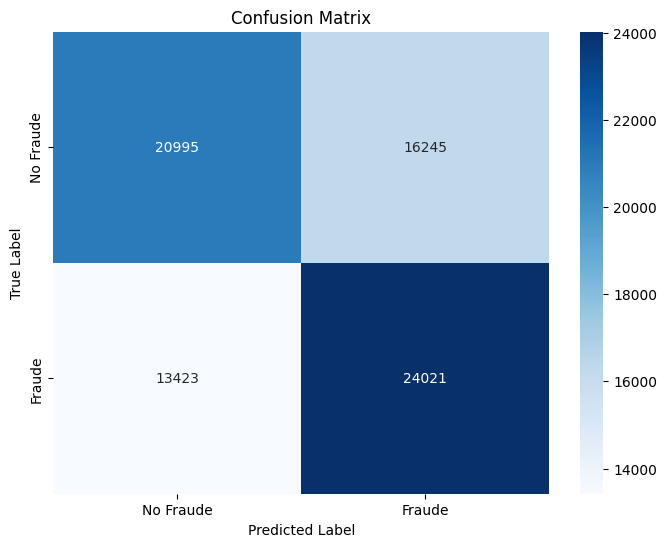

In [67]:
cm = confusion_matrix(y_test, np.round(prv.squeeze(), 0))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Fraude', 'Fraude'],
            yticklabels=['No Fraude', 'Fraude'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [68]:
prv

array([[0.3289282 ],
       [0.35403532],
       [0.5962876 ],
       ...,
       [0.38106984],
       [0.5369492 ],
       [0.65316325]], dtype=float32)

In [69]:
comp = pd.DataFrame(data={'real': y_test, 'prev': np.round(prv.squeeze(), 0)})

In [70]:
comp['acc'] = comp.real == comp.prev

In [71]:
comp['acc'].sum() / len(comp)

0.6027529323549891

In [72]:
matriz = comp.pivot_table(index='real', columns='prev', values='acc', aggfunc='count')

In [73]:
matriz / matriz.sum(axis=1)

prev,0.0,1.0
real,,
0,0.563776,0.433848
1,0.360446,0.641518
